In [1]:
# conda install -c conda-forge openexr

In [2]:
import os
import ntpath
import re

import math

import multiprocessing as mp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import operator
#from operator import add
#from operator import 

#import runai.ga

#from nvidia.dali.pipeline import Pipeline
#import nvidia.dali.ops as ops
#import nvidia.dali.types as types

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils.np_utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa

import tensorflow as tf
from tensorflow.python.client import device_lib

import datetime

import cv2
import pandas as pd
import random
from IPython.display import Image
from pathlib import Path

import glob
import json
#import OpenEXR
import imageio

In [3]:
print( "Number of processors: ", mp.cpu_count() )

Number of processors:  32


In [4]:
def load_obj_data( jsonfile ):
    json_path = os.path.join( path_to_images, jsonfile )
    with open( json_path, 'r' ) as infile:
        data = json.load( infile )
    return data

In [5]:
def get_file_name( json_data ):
    img_files_pre = json_data[ "frame" ][ "files" ]
    img_files = [ os.path.normpath( f ) for f in img_files_pre ]
    path_img           = [ f for f in img_files if re.match(r'.*_img[0-9]+\.(png|jpeg|jpg)', f ) ][ 0 ]
    path_img_z_map     = [ f for f in img_files if re.match(r'.*_z[0-9]+\.exr', f ) ][ 0 ]
    path_img_class     = [ f for f in img_files if re.match(r'.*_class[0-9]+\.(png|jpeg|jpg)', f )][ 0 ]
    path_img_z_img     = [ f for f in img_files if re.match(r'.*_z_img[0-9]+\.(png|jpeg|jpg)', f )][ 0 ]
    path_img_class_img = [ f for f in img_files if re.match(r'.*_class_img[0-9]+\.(png|jpeg|jpg)', f )][ 0 ]
    return ( path_img, path_img_z_map, path_img_class, path_img_z_img, path_img_class_img )

In [6]:
#def img_preprocess_load( img_path ):
#    img = mpimg.imread( img_path )
#    img = img_preprocess( img )
#    return img

In [7]:
#def img_preprocess( img ):
#    img = img[ 60:135, :, : ]
#    img = cv2.cvtColor( img, cv2.COLOR_RGB2YUV )
#    img = cv2.GaussianBlur( img, ( 3, 3 ), 0 )
#    img = cv2.resize( img, ( 200, 66 ) )
#    img = img / 255
#    return img

In [8]:
def img_rm_alpha( img_orig ):
    img = np.copy( img_orig )
    h, w, cp = img.shape
    if cp == 4:
        for y in range( h - 1 ):
            for x in range( w - 1 ):
                img[y][x][3]=1
    return img

In [9]:
# set to true to get more output for debugging issues
print_debug = False

# path to folder with all json files with object information
path_to_images = "C:\\tmp\\dump_truck4"
#path_to_images = "C:\\tmp\\test"


included_extensions = [ 'json' ] #, 'jpg','jpeg', 'bmp', 'png', 'gif']
obj_data_files = [ fn for fn in os.listdir( path_to_images )
                      if any( fn.endswith( ext ) for ext in included_extensions ) ]
print( "Found ", len( obj_data_files ), " json files" )

Found  1001  json files


path_img           =  C:\tmp\dump_truck4\minetruck_img0205.png
path_img_z_map     =  C:\tmp\dump_truck4\minetruck_z0205.exr
path_img_class     =  C:\tmp\dump_truck4\minetruck_class0205.png
path_img_z_map     =  C:\tmp\dump_truck4\minetruck_z_img0205.jpg
path_img_class_img =  C:\tmp\dump_truck4\minetruck_class_img0205.jpg
(1024, 1280, 4)
(1024, 1280, 3)
(1024, 1280)
(1024, 1280, 3)
(1024, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Class 2')

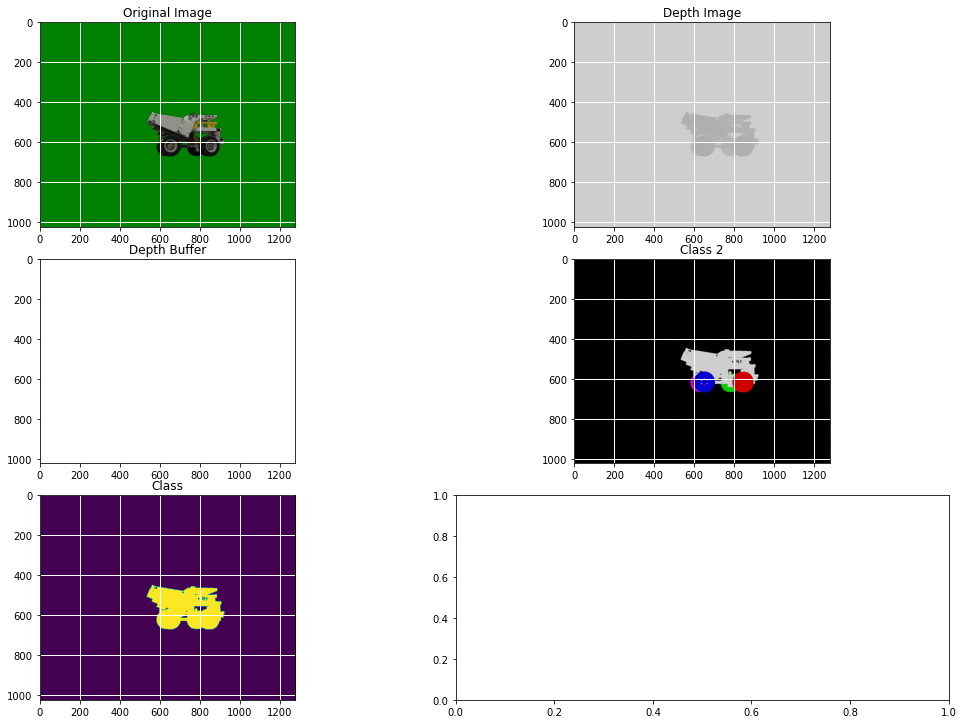

In [10]:
obj_data_idx = random.randint( 0, len( obj_data_files ) - 1 )
obj_data_path = obj_data_files[ obj_data_idx ]
obj_data = load_obj_data(obj_data_path)

obj_data["frame"]["files"]

#####################################################################

path_img, path_img_z_map, path_img_class, path_img_z_img, path_img_class_img = get_file_name(obj_data)
print("path_img           = ", path_img)
print("path_img_z_map     = ", path_img_z_map)
print("path_img_class     = ", path_img_class)
print("path_img_z_map     = ", path_img_z_img)
print("path_img_class_img = ", path_img_class_img)

#pp = "C:\\tmp\\dump_truck4\\minetruck_img0310.jpg"
#my_file = Path(pp)
#print(pp, " is a file ", os.path.isfile(pp) )
#print(pp, " is a file ", os.path.isdir(pp) )
#print(pp, " is a file ", my_file.exists() )

#img             = mpimg.imread( pp )
#img_z_map       = img
img           = mpimg.imread( path_img )
img_z_map     = imageio.imread( path_img_z_map )
img_class     = mpimg.imread( path_img_class )
img_z_img     = mpimg.imread( path_img_z_img )
img_class_img = mpimg.imread( path_img_class_img )

print (img.shape)
print (img_z_map.shape)
print (img_class.shape)
print (img_z_img.shape)
print (img_class_img.shape)
#print (golden[512][640])


fig, axs = plt.subplots( 3, 2, figsize = ( 15, 10 ) )
fig.tight_layout()
axs[ 0 ][ 0 ].set_facecolor("green")
#axs[ 0 ][ 0 ].fill_between([0,1],[1,1], color="none", hatch="X", edgecolor="b", linewidth=0.0)
axs[ 0 ][ 0 ].imshow( img )
axs[ 0 ][ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 0 ][ 0 ].set_title( 'Original Image' )

axs[ 1 ][ 0 ].set_facecolor("green")
axs[ 1 ][ 0 ].imshow( img_z_map )
axs[ 1 ][ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 1 ][ 0 ].set_title( 'Depth Buffer' )

axs[ 2 ][ 0 ].set_facecolor("green")
axs[ 2 ][ 0 ].imshow( img_class )
axs[ 2 ][ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 2 ][ 0 ].set_title( 'Class' )

axs[ 0 ][ 1 ].set_facecolor("green")
axs[ 0 ][ 1 ].imshow( img_z_img )
axs[ 0 ][ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 0 ][ 1 ].set_title( 'Depth Image' )

axs[ 1 ][ 1 ].set_facecolor("green")
axs[ 1 ][ 1 ].imshow( img_class_img )
axs[ 1 ][ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 1 ][ 1 ].set_title( 'Class 2' )

#show_image("minetruck_img1001.jpg")
#obj_data["frame"][0]["objects"]["object_0000"]

In [11]:
def img_rect( img_orig, rects ):
    img = img_rm_alpha( img_orig )
    h, w, cp = img.shape
    print ("H,W,CP = ", h, w, cp)
    for rect in rects:
        (p1, p2, color) = rect
        p1s = ( int(p1[0] * w), int(h - p1[1] * h) )
        p2s = ( int(p2[0] * w), int(h - p2[1] * h) )
        cv2.rectangle( img, p1s, p2s, color, 5 )
    alpha = 0.4  # Transparency factor.
    # Following line overlays transparent rectangle over the image
    img = cv2.addWeighted(img, alpha, img_orig, 1 - alpha, 0)
    return img

def rnd_color():
    r = min(random.randint(0, 8) * 32, 255)
    g = min(random.randint(0, 8) * 32, 255)
    b = min(random.randint(0, 8) * 32, 255)
    return (r, g, b)

def get_bb(data, objName):
    c = rnd_color()
    if print_debug:
        print ("Color for ", objName, " is ", c)

    objData = data["frame"]["objects"][objName]
    if "bb2dWithChildren" in objData:
        bb2d = objData["bb2dWithChildren"]
    elif "bb2d" in objData:
        bb2d = objData["bb2d"]
    if bb2d:
        rect = ( ( bb2d["x1"], bb2d["y1"] ), ( bb2d["x2"], bb2d["y2"] ), c )
    else:
        rect = ( ( 0, 0 ), ( 0, 0 ) )
    return rect

In [12]:
def output_bounding_box(values):
    # output debugging information about the bounding boxes
    if "bb2d" in values:
        print("{}\t{}\tbb2d=({:.2},{:.2},{:.2},{:.2})".format(keys,values["name"],values["bb2d"]["x1"],values["bb2d"]["y1"],values["bb2d"]["x2"],values["bb2d"]["y2"]) )
    if "bb2dWithChildren" in values:
        print("{}\t{}\tbb2dWC=({:.2},{:.2},{:.2},{:.2})".format(keys,values["name"],values["bb2dWithChildren"]["x1"],values["bb2dWithChildren"]["y1"],values["bb2dWithChildren"]["x2"],values["bb2dWithChildren"]["y2"]) )

In [13]:
# requires an image with alpha channel
# returns the area that has a non-zero alpha values,
# described by ( ( offset_x, offset_y ), ( width, height ) )
def get_nontransparent_area( img ):
    offset_x = 0
    offset_y = 0
    ( size_x, size_y ) = img.shape[ 0 : 2 ]

    line_is_transparent = True
    while offset_x < size_x and line_is_transparent:
        line_is_transparent = ( np.amax( img[ offset_x , ::, 3:4: ] ) == 0 )
        offset_x = offset_x + 1

    line_is_transparent = True
    while offset_y < size_y and line_is_transparent:
        line_is_transparent = ( np.amax( img[ ::, offset_y , 3:4: ] ) == 0 )
        offset_y = offset_y + 1

    size_x = size_x - offset_x
    size_y = size_y - offset_y

    line_is_transparent = True
    while size_x > 0 and line_is_transparent:
        line_is_transparent = ( np.amax( img[ offset_x + size_x - 1 , ::, 3:4: ] ) == 0 )
        size_x = size_x - 1

    line_is_transparent = True
    while size_y > 0 and line_is_transparent:
        line_is_transparent = ( np.amax( img[ ::, offset_y + size_y - 1 , 3:4: ] ) == 0 )
        size_y = size_y - 1

    offset = ( offset_x, offset_y )
    size = ( size_x, size_y )
    return (offset, size)

In [134]:
print_debug = False

def loadFileInfo( obj_data_path ):
    #objs = [ "Cube.000", "Cube.002", "Cube.003" ]
    #objs = [ "Car Rig", "wheel.Ft.L", "wheel.Ft.R", "wheel.Bk.L", "wheel.Bk.R", "body", "Minetruck" ]
    #objs = [ "wheel.Ft.L", "wheel.Ft.R", "wheel.Bk.L", "wheel.Bk.R", "body", "Minetruck" ]
    #objs = [ "testcar-Body", "testcar-Wheel.Ft.L", "testcar-Wheel.Ft.R", "testcar-Wheel.Bk.L", "testcar-Wheel.Bk.R", "Car Rig" ]
    objs = [ "Car Rig", "wheel.Ft.L", "wheel.Ft.R", "wheel.Bk.L", "wheel.Bk.R" ]

    # load json information
    data = load_obj_data( obj_data_path )

    # load image for this description
    path_img, path_img_z_map, path_img_class, path_img_z_img, path_img_class_img = get_file_name( data )
    #if print_debug:
    print ( "Loading ", obj_data_path, " using image file ", path_img )
    img_original = mpimg.imread( path_img )

    if print_debug:
        # output debugging information about the bounding boxes
        for keys, values in data[ "frame" ][ "objects" ].items():
            output_bounding_box( values )

    # find information about the steering of the vehicle
    for keys, values in data[ "frame" ][ "objects" ][ objs[ 0 ] ][ "pose" ][ "bones" ].items():
        if values[ "name" ] == "Steering":
            steering_bone = values
        elif values[ "name" ] == "GroundSensor.Axle.Ft":
            front_axle_bone = values

    if print_debug and steering_bone:
        print( "Found steering bone: ", steering_bone[ "head" ] )
    if print_debug and front_axle_bone:
        print( "Found front axle bone: ", front_axle_bone[ "head" ] )
    steering_angle = 0.0
    if steering_bone[ "head" ][ "y" ] != 0.0:
        diff_x = steering_bone[ "head" ][ "x" ] - front_axle_bone[ "head" ][ "x" ]
        diff_y = steering_bone[ "head" ][ "y" ] - front_axle_bone[ "head" ][ "y" ]
        steering_angle = 180.0 / math.pi * math.atan( diff_x / diff_y )
    if print_debug:
        print( "steering_angle = ", steering_angle, " degree" )

    nontransparent_area = get_nontransparent_area( img_original )
    rects = [ get_bb( data, o ) for o in objs ]
    return ( steering_angle, rects, img_original, nontransparent_area )

In [14]:
# run single-threaded
objectInfos = [ loadFileInfo( n ) for n in obj_data_files ]

# run multi-threaded:
#with mp.Pool( processes = mp.cpu_count() ) as pool:
#    objectInfos = pool.map( loadFileInfo, [ n for n in obj_data_files[ :20 ] ] )

Loading  obj_data0001.json  using image file  C:\tmp\dump_truck4\minetruck_img0001.png
Loading  obj_data0002.json  using image file  C:\tmp\dump_truck4\minetruck_img0002.png
Loading  obj_data0003.json  using image file  C:\tmp\dump_truck4\minetruck_img0003.png
Loading  obj_data0004.json  using image file  C:\tmp\dump_truck4\minetruck_img0004.png
Loading  obj_data0005.json  using image file  C:\tmp\dump_truck4\minetruck_img0005.png
Loading  obj_data0006.json  using image file  C:\tmp\dump_truck4\minetruck_img0006.png
Loading  obj_data0007.json  using image file  C:\tmp\dump_truck4\minetruck_img0007.png
Loading  obj_data0008.json  using image file  C:\tmp\dump_truck4\minetruck_img0008.png
Loading  obj_data0009.json  using image file  C:\tmp\dump_truck4\minetruck_img0009.png
Loading  obj_data0010.json  using image file  C:\tmp\dump_truck4\minetruck_img0010.png
Loading  obj_data0011.json  using image file  C:\tmp\dump_truck4\minetruck_img0011.png
Loading  obj_data0012.json  using image fil

Loading  obj_data0097.json  using image file  C:\tmp\dump_truck4\minetruck_img0097.png
Loading  obj_data0098.json  using image file  C:\tmp\dump_truck4\minetruck_img0098.png
Loading  obj_data0099.json  using image file  C:\tmp\dump_truck4\minetruck_img0099.png
Loading  obj_data0100.json  using image file  C:\tmp\dump_truck4\minetruck_img0100.png
Loading  obj_data0101.json  using image file  C:\tmp\dump_truck4\minetruck_img0101.png
Loading  obj_data0102.json  using image file  C:\tmp\dump_truck4\minetruck_img0102.png
Loading  obj_data0103.json  using image file  C:\tmp\dump_truck4\minetruck_img0103.png
Loading  obj_data0104.json  using image file  C:\tmp\dump_truck4\minetruck_img0104.png
Loading  obj_data0105.json  using image file  C:\tmp\dump_truck4\minetruck_img0105.png
Loading  obj_data0106.json  using image file  C:\tmp\dump_truck4\minetruck_img0106.png
Loading  obj_data0107.json  using image file  C:\tmp\dump_truck4\minetruck_img0107.png
Loading  obj_data0108.json  using image fil

Loading  obj_data0192.json  using image file  C:\tmp\dump_truck4\minetruck_img0192.png
Loading  obj_data0193.json  using image file  C:\tmp\dump_truck4\minetruck_img0193.png
Loading  obj_data0194.json  using image file  C:\tmp\dump_truck4\minetruck_img0194.png
Loading  obj_data0195.json  using image file  C:\tmp\dump_truck4\minetruck_img0195.png
Loading  obj_data0196.json  using image file  C:\tmp\dump_truck4\minetruck_img0196.png
Loading  obj_data0197.json  using image file  C:\tmp\dump_truck4\minetruck_img0197.png
Loading  obj_data0198.json  using image file  C:\tmp\dump_truck4\minetruck_img0198.png
Loading  obj_data0199.json  using image file  C:\tmp\dump_truck4\minetruck_img0199.png
Loading  obj_data0200.json  using image file  C:\tmp\dump_truck4\minetruck_img0200.png
Loading  obj_data0201.json  using image file  C:\tmp\dump_truck4\minetruck_img0201.png
Loading  obj_data0202.json  using image file  C:\tmp\dump_truck4\minetruck_img0202.png
Loading  obj_data0203.json  using image fil

Loading  obj_data0290.json  using image file  C:\tmp\dump_truck4\minetruck_img0290.png
Loading  obj_data0291.json  using image file  C:\tmp\dump_truck4\minetruck_img0291.png
Loading  obj_data0292.json  using image file  C:\tmp\dump_truck4\minetruck_img0292.png
Loading  obj_data0293.json  using image file  C:\tmp\dump_truck4\minetruck_img0293.png
Loading  obj_data0294.json  using image file  C:\tmp\dump_truck4\minetruck_img0294.png
Loading  obj_data0295.json  using image file  C:\tmp\dump_truck4\minetruck_img0295.png
Loading  obj_data0296.json  using image file  C:\tmp\dump_truck4\minetruck_img0296.png
Loading  obj_data0297.json  using image file  C:\tmp\dump_truck4\minetruck_img0297.png
Loading  obj_data0298.json  using image file  C:\tmp\dump_truck4\minetruck_img0298.png
Loading  obj_data0299.json  using image file  C:\tmp\dump_truck4\minetruck_img0299.png
Loading  obj_data0300.json  using image file  C:\tmp\dump_truck4\minetruck_img0300.png
Loading  obj_data0301.json  using image fil

Loading  obj_data0389.json  using image file  C:\tmp\dump_truck4\minetruck_img0389.png
Loading  obj_data0390.json  using image file  C:\tmp\dump_truck4\minetruck_img0390.png
Loading  obj_data0391.json  using image file  C:\tmp\dump_truck4\minetruck_img0391.png
Loading  obj_data0392.json  using image file  C:\tmp\dump_truck4\minetruck_img0392.png
Loading  obj_data0393.json  using image file  C:\tmp\dump_truck4\minetruck_img0393.png
Loading  obj_data0394.json  using image file  C:\tmp\dump_truck4\minetruck_img0394.png
Loading  obj_data0395.json  using image file  C:\tmp\dump_truck4\minetruck_img0395.png
Loading  obj_data0396.json  using image file  C:\tmp\dump_truck4\minetruck_img0396.png
Loading  obj_data0397.json  using image file  C:\tmp\dump_truck4\minetruck_img0397.png
Loading  obj_data0398.json  using image file  C:\tmp\dump_truck4\minetruck_img0398.png
Loading  obj_data0399.json  using image file  C:\tmp\dump_truck4\minetruck_img0399.png
Loading  obj_data0400.json  using image fil

Loading  obj_data0486.json  using image file  C:\tmp\dump_truck4\minetruck_img0486.png
Loading  obj_data0487.json  using image file  C:\tmp\dump_truck4\minetruck_img0487.png
Loading  obj_data0488.json  using image file  C:\tmp\dump_truck4\minetruck_img0488.png
Loading  obj_data0489.json  using image file  C:\tmp\dump_truck4\minetruck_img0489.png
Loading  obj_data0490.json  using image file  C:\tmp\dump_truck4\minetruck_img0490.png
Loading  obj_data0491.json  using image file  C:\tmp\dump_truck4\minetruck_img0491.png
Loading  obj_data0492.json  using image file  C:\tmp\dump_truck4\minetruck_img0492.png
Loading  obj_data0493.json  using image file  C:\tmp\dump_truck4\minetruck_img0493.png
Loading  obj_data0494.json  using image file  C:\tmp\dump_truck4\minetruck_img0494.png
Loading  obj_data0495.json  using image file  C:\tmp\dump_truck4\minetruck_img0495.png
Loading  obj_data0496.json  using image file  C:\tmp\dump_truck4\minetruck_img0496.png
Loading  obj_data0497.json  using image fil

Loading  obj_data0585.json  using image file  C:\tmp\dump_truck4\minetruck_img0585.png
Loading  obj_data0586.json  using image file  C:\tmp\dump_truck4\minetruck_img0586.png
Loading  obj_data0587.json  using image file  C:\tmp\dump_truck4\minetruck_img0587.png
Loading  obj_data0588.json  using image file  C:\tmp\dump_truck4\minetruck_img0588.png
Loading  obj_data0589.json  using image file  C:\tmp\dump_truck4\minetruck_img0589.png
Loading  obj_data0590.json  using image file  C:\tmp\dump_truck4\minetruck_img0590.png
Loading  obj_data0591.json  using image file  C:\tmp\dump_truck4\minetruck_img0591.png
Loading  obj_data0592.json  using image file  C:\tmp\dump_truck4\minetruck_img0592.png
Loading  obj_data0593.json  using image file  C:\tmp\dump_truck4\minetruck_img0593.png
Loading  obj_data0594.json  using image file  C:\tmp\dump_truck4\minetruck_img0594.png
Loading  obj_data0595.json  using image file  C:\tmp\dump_truck4\minetruck_img0595.png
Loading  obj_data0596.json  using image fil

Loading  obj_data0680.json  using image file  C:\tmp\dump_truck4\minetruck_img0680.png
Loading  obj_data0681.json  using image file  C:\tmp\dump_truck4\minetruck_img0681.png
Loading  obj_data0682.json  using image file  C:\tmp\dump_truck4\minetruck_img0682.png
Loading  obj_data0683.json  using image file  C:\tmp\dump_truck4\minetruck_img0683.png
Loading  obj_data0684.json  using image file  C:\tmp\dump_truck4\minetruck_img0684.png
Loading  obj_data0685.json  using image file  C:\tmp\dump_truck4\minetruck_img0685.png
Loading  obj_data0686.json  using image file  C:\tmp\dump_truck4\minetruck_img0686.png
Loading  obj_data0687.json  using image file  C:\tmp\dump_truck4\minetruck_img0687.png
Loading  obj_data0688.json  using image file  C:\tmp\dump_truck4\minetruck_img0688.png
Loading  obj_data0689.json  using image file  C:\tmp\dump_truck4\minetruck_img0689.png
Loading  obj_data0690.json  using image file  C:\tmp\dump_truck4\minetruck_img0690.png
Loading  obj_data0691.json  using image fil

Loading  obj_data0778.json  using image file  C:\tmp\dump_truck4\minetruck_img0778.png
Loading  obj_data0779.json  using image file  C:\tmp\dump_truck4\minetruck_img0779.png
Loading  obj_data0780.json  using image file  C:\tmp\dump_truck4\minetruck_img0780.png
Loading  obj_data0781.json  using image file  C:\tmp\dump_truck4\minetruck_img0781.png
Loading  obj_data0782.json  using image file  C:\tmp\dump_truck4\minetruck_img0782.png
Loading  obj_data0783.json  using image file  C:\tmp\dump_truck4\minetruck_img0783.png
Loading  obj_data0784.json  using image file  C:\tmp\dump_truck4\minetruck_img0784.png
Loading  obj_data0785.json  using image file  C:\tmp\dump_truck4\minetruck_img0785.png
Loading  obj_data0786.json  using image file  C:\tmp\dump_truck4\minetruck_img0786.png
Loading  obj_data0787.json  using image file  C:\tmp\dump_truck4\minetruck_img0787.png
Loading  obj_data0788.json  using image file  C:\tmp\dump_truck4\minetruck_img0788.png
Loading  obj_data0789.json  using image fil

Loading  obj_data0873.json  using image file  C:\tmp\dump_truck4\minetruck_img0873.png
Loading  obj_data0874.json  using image file  C:\tmp\dump_truck4\minetruck_img0874.png
Loading  obj_data0875.json  using image file  C:\tmp\dump_truck4\minetruck_img0875.png
Loading  obj_data0876.json  using image file  C:\tmp\dump_truck4\minetruck_img0876.png
Loading  obj_data0877.json  using image file  C:\tmp\dump_truck4\minetruck_img0877.png
Loading  obj_data0878.json  using image file  C:\tmp\dump_truck4\minetruck_img0878.png
Loading  obj_data0879.json  using image file  C:\tmp\dump_truck4\minetruck_img0879.png
Loading  obj_data0880.json  using image file  C:\tmp\dump_truck4\minetruck_img0880.png
Loading  obj_data0881.json  using image file  C:\tmp\dump_truck4\minetruck_img0881.png
Loading  obj_data0882.json  using image file  C:\tmp\dump_truck4\minetruck_img0882.png
Loading  obj_data0883.json  using image file  C:\tmp\dump_truck4\minetruck_img0883.png
Loading  obj_data0884.json  using image fil

Loading  obj_data0971.json  using image file  C:\tmp\dump_truck4\minetruck_img0971.png
Loading  obj_data0972.json  using image file  C:\tmp\dump_truck4\minetruck_img0972.png
Loading  obj_data0973.json  using image file  C:\tmp\dump_truck4\minetruck_img0973.png
Loading  obj_data0974.json  using image file  C:\tmp\dump_truck4\minetruck_img0974.png
Loading  obj_data0975.json  using image file  C:\tmp\dump_truck4\minetruck_img0975.png
Loading  obj_data0976.json  using image file  C:\tmp\dump_truck4\minetruck_img0976.png
Loading  obj_data0977.json  using image file  C:\tmp\dump_truck4\minetruck_img0977.png
Loading  obj_data0978.json  using image file  C:\tmp\dump_truck4\minetruck_img0978.png
Loading  obj_data0979.json  using image file  C:\tmp\dump_truck4\minetruck_img0979.png
Loading  obj_data0980.json  using image file  C:\tmp\dump_truck4\minetruck_img0980.png
Loading  obj_data0981.json  using image file  C:\tmp\dump_truck4\minetruck_img0981.png
Loading  obj_data0982.json  using image fil

In [15]:
# draw the plots + bounding boxes
#fig, axs = plt.subplots( 1, 1, figsize = ( 15, 30 ) )
#fig.tight_layout()
#obj_data_idx = 948 #random.randint( 0, len( objectInfos ) - 1 )
#( steering_angle, bbs, img ) = loadFileInfo( obj_data_files[ obj_data_idx ] )
#print ( "steering angle = ", steering_angle, " for image ", obj_data_idx )
#axs.imshow( img_rect( img, bbs ) )
#axs.grid( color='w', linestyle='-', linewidth = 1 )

steering angle =  19.45632929093593  for image  779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  -19.456326340470433  for image  115


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  -12.621155329706342  for image  281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  18.874643983436137  for image  693


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  17.29403150336507  for image  652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  -12.538432156091636  for image  282


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  -19.45632710274774  for image  99


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  -19.456323017834343  for image  31


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4


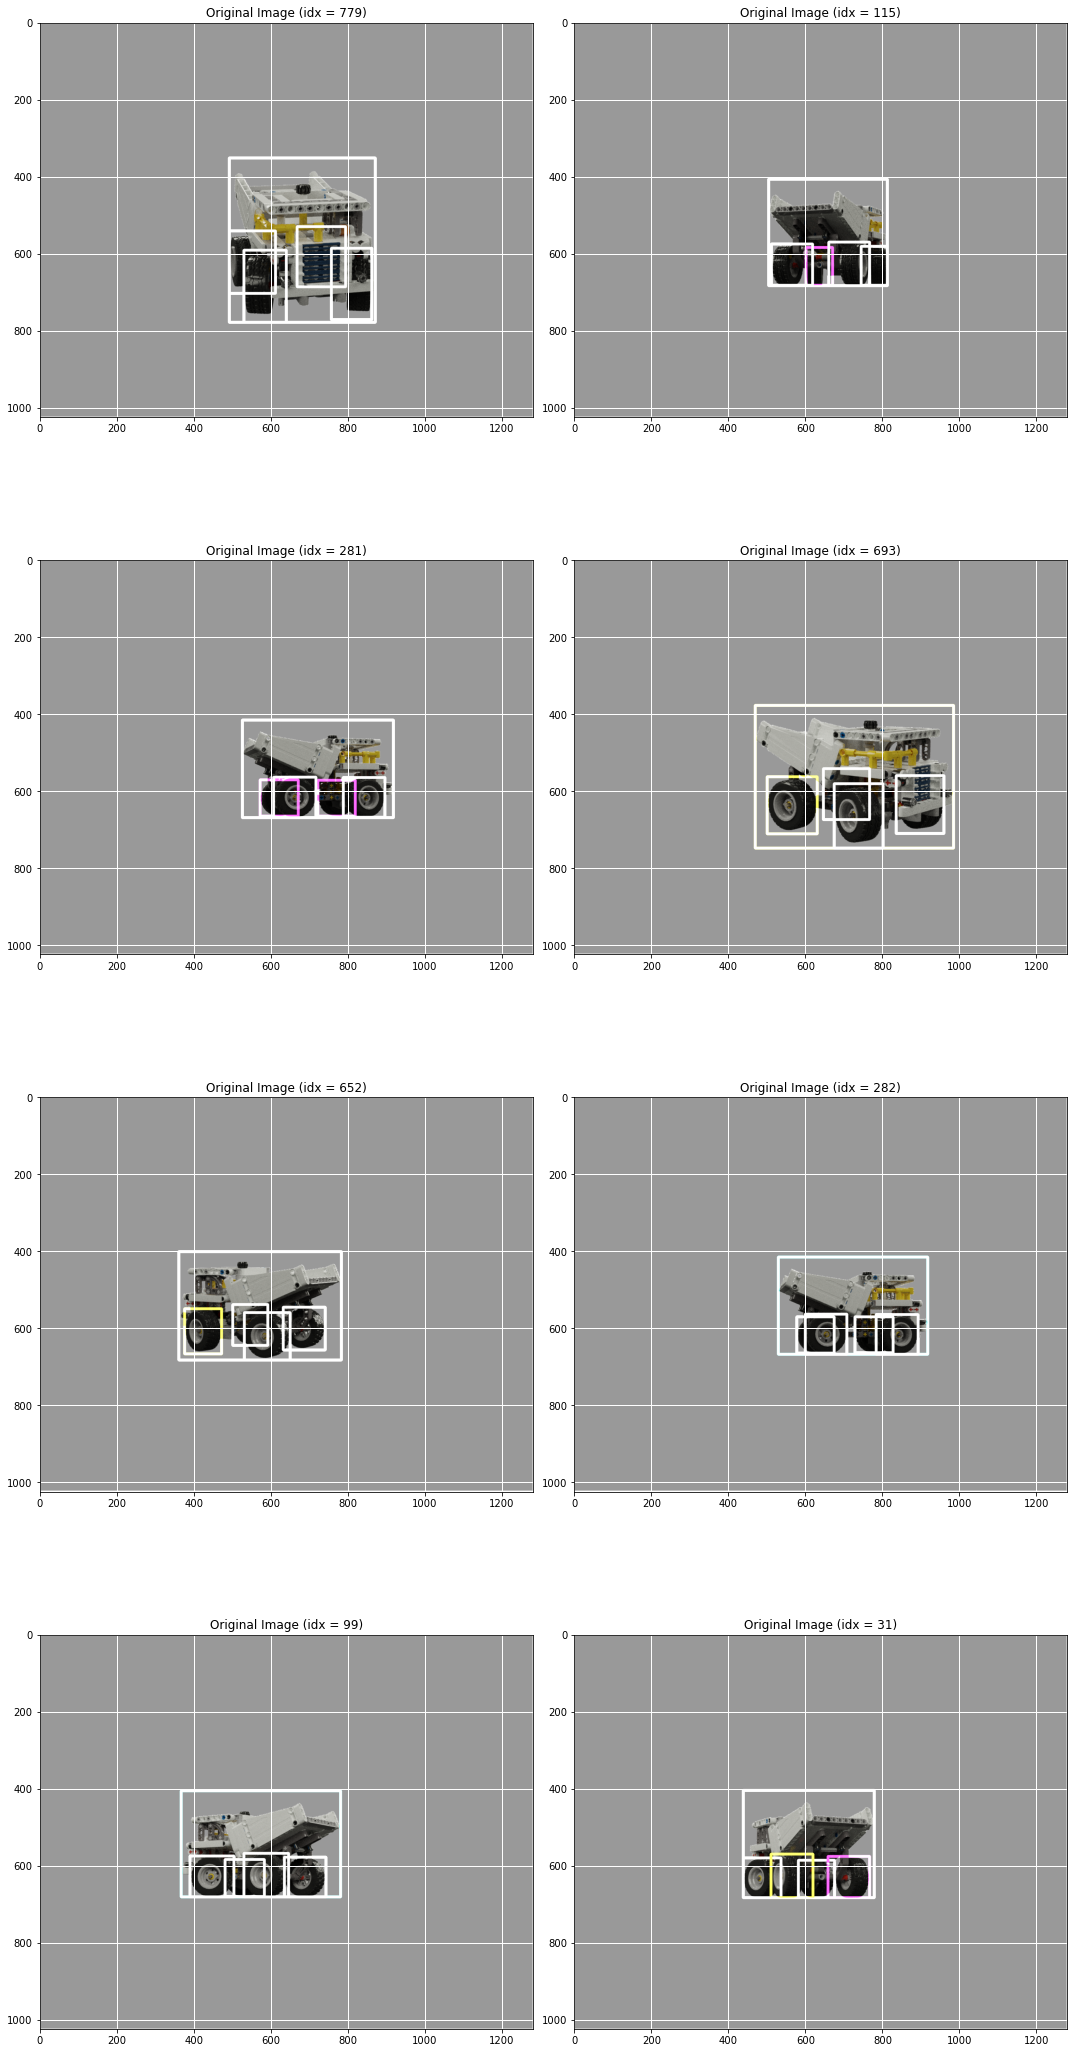

In [16]:
# draw the plots + bounding boxes
fig, axs = plt.subplots( 4, 2, figsize = ( 15, 30 ) )
fig.tight_layout()
for y in range(4):
    for x in range(2):
        obj_data_idx = random.randint( 0, len( objectInfos ) - 1 )
        ( steering_angle, bbs, img, _ ) = objectInfos[ obj_data_idx ]
        print ( "steering angle = ", steering_angle, " for image ", obj_data_idx )
        axs[ y, x ].imshow( img_rect( img, bbs ) )
        axs[ y, x ].grid( color='w', linestyle='-', linewidth = 1 )
        axs[ y, x ].set_title( 'Original Image (idx = ' + str( obj_data_idx ) + ')' )

In [17]:
image_extensions = [ 'jpg','jpeg', 'bmp', 'png', 'gif']
background_image_source_folder = "S:\\Bilder_Filme"

def get_sub_dirs( p ):
    subdirs = [ p ]
    for x in p.iterdir():
        if x.is_dir():
            subdirs = subdirs + get_sub_dirs( x )
    return subdirs


bgimg_path = Path( background_image_source_folder )
subdirs = get_sub_dirs( Path( bgimg_path ) )
img_files = []
for path in subdirs:
    print ( "Checking ", path )
    img_files = img_files + [ os.path.join( path, fn ) for fn in os.listdir( path ) if any( fn.endswith( ext ) for ext in image_extensions ) ]

print( "Found ", len( img_files ), " images files" )
print( "Images: ", img_files )

Checking  S:\Bilder_Filme
Checking  S:\Bilder_Filme\2009 SchauinsLandTour
Checking  S:\Bilder_Filme\2011-08 Urlaub - Tirol
Checking  S:\Bilder_Filme\2012 Liverpool
Checking  S:\Bilder_Filme\2012 Liverpool\Filme
Checking  S:\Bilder_Filme\2013 München
Checking  S:\Bilder_Filme\2013-04-12 Wanderung mit Armin und Steffen
Checking  S:\Bilder_Filme\2013-05-03 Radtour mit Martin
Checking  S:\Bilder_Filme\2014 Jahresfeier Informatik
Checking  S:\Bilder_Filme\2014 München
Checking  S:\Bilder_Filme\2014-06-18 Wandern mit Steffen
Checking  S:\Bilder_Filme\2015 MxSnow
Checking  S:\Bilder_Filme\2015 MxSnow\2015-Ischgl
Checking  S:\Bilder_Filme\2015 MxSnow\2015-Ischgl alles
Checking  S:\Bilder_Filme\2015 MxSnow\2015-Ischgl alles\mxsnow2015
Checking  S:\Bilder_Filme\2015 MxSnow\2015-Ischgl alles\mxsnow2015\dokumente
Checking  S:\Bilder_Filme\2015 MxSnow\2015-Ischgl alles\mxsnow2015\fotos
Checking  S:\Bilder_Filme\2015 MxSnow\2015-Ischgl alles\mxsnow2015\musik
Checking  S:\Bilder_Filme\2015 MxSnow\201

Checking  S:\Bilder_Filme\2018-05-12 Speyer - Brazzeltag\HDR1\DSC04719_20_21_22_23_24_25_26_27.data
Checking  S:\Bilder_Filme\2018-05-12 Speyer - Brazzeltag\HDR2
Checking  S:\Bilder_Filme\2018-05-12 Speyer - Brazzeltag\HDR2\DSC04728_29_30_31_32_33_34_35_36.data
Checking  S:\Bilder_Filme\2018-05-12 Speyer - Brazzeltag\HDR3
Checking  S:\Bilder_Filme\2018-05-12 Speyer - Brazzeltag\HDR3\DSC04737_38_39_40_41_42_43_44_45.data
Checking  S:\Bilder_Filme\2018-05-12 Speyer - Brazzeltag\HDR4
Checking  S:\Bilder_Filme\2018-05-12 Speyer - Brazzeltag\HDR4\DSC04748_49_50_51_52_53_54_55_56.data
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\Daniel
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR\hdr01 - Kopie
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR\hdr01 - Kopie\DSC06511_2_3_4_5.data
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR\hdr01 - Kopie\DSC06511_2_3_4_

Checking  S:\Bilder_Filme\2018-08 Flughafenfest
Checking  S:\Bilder_Filme\2018-08 PC Build
Checking  S:\Bilder_Filme\2018-08 PC Build\HDR
Checking  S:\Bilder_Filme\2018-08 PC Build\video
Checking  S:\Bilder_Filme\2018-08-05 Schwarzwaldtour
Checking  S:\Bilder_Filme\2018-08-05 Schwarzwaldtour\done
Checking  S:\Bilder_Filme\2018-08-05 Schwarzwaldtour\results
Checking  S:\Bilder_Filme\2018-08-05 Schwarzwaldtour\[Entwickelt]
Checking  S:\Bilder_Filme\2018-08-05 Schwarzwaldtour\[Originaldateien]
Checking  S:\Bilder_Filme\2018-09 Schwarzenbachtalsperre
Checking  S:\Bilder_Filme\2018-09 Schwarzenbachtalsperre\hdr1
Checking  S:\Bilder_Filme\2018-09 Schwarzenbachtalsperre\hdr1\DSC09269_70___77.data
Checking  S:\Bilder_Filme\2018-09 Schwarzenbachtalsperre\hdr1\DSC09269_70___77.data\SelectivePainter
Checking  S:\Bilder_Filme\2018-09 Schwarzenbachtalsperre\hdr1\DSC09271.data
Checking  S:\Bilder_Filme\2018-09 Schwarzenbachtalsperre\hdr1\DSC09271.data\SelectivePainter
Checking  S:\Bilder_Filme\2018-

Checking  S:\Bilder_Filme\2019-06-30 Milky Way auf Schliffkopf\a6500\sasbach1
Checking  S:\Bilder_Filme\2019-06-30 Milky Way auf Schliffkopf\a6500\sumith
Checking  S:\Bilder_Filme\2019-06-30 Milky Way auf Schliffkopf\a6500\sumith\ungenutzt
Checking  S:\Bilder_Filme\2019-06-30 Milky Way auf Schliffkopf\a6500\sumith\[Originaldateien]
Checking  S:\Bilder_Filme\2019-06-30 Milky Way auf Schliffkopf\a6500\timelapse
Checking  S:\Bilder_Filme\2019-06-30 Milky Way auf Schliffkopf\a6500\timelapse\earth_rot_compensated
Checking  S:\Bilder_Filme\2019-06-30 Milky Way auf Schliffkopf\a6500\timelapse\earth_rot_compensated2
Checking  S:\Bilder_Filme\2019-06-30 Milky Way auf Schliffkopf\a6500\timelapse\earth_rot_compensated3
Checking  S:\Bilder_Filme\2019-06-30 Milky Way auf Schliffkopf\a6500\timelapse\jpeg
Checking  S:\Bilder_Filme\2019-06-30 Milky Way auf Schliffkopf\a6500\timelapse\tiff
Checking  S:\Bilder_Filme\2019-06-30 Milky Way auf Schliffkopf\a6500\timelapse\tiff2
Checking  S:\Bilder_Filme\201

Checking  S:\Bilder_Filme\2019-08-10 Oberstdorf Alpen\Timelapses\Timelapse3e\raw
Checking  S:\Bilder_Filme\2019-08-10 Oberstdorf Alpen\Timelapses\Timelapse3e\tiff
Checking  S:\Bilder_Filme\2019-08-10 Oberstdorf Alpen\Timelapses\Timelapse3e\tiff_adjusted
Checking  S:\Bilder_Filme\2019-08-10 Oberstdorf Alpen\Timelapses\Timelapse3f
Checking  S:\Bilder_Filme\2019-08-10 Oberstdorf Alpen\Timelapses\Timelapse3f\raw
Checking  S:\Bilder_Filme\2019-08-10 Oberstdorf Alpen\Timelapses\Timelapse3f\tiff
Checking  S:\Bilder_Filme\2019-08-10 Oberstdorf Alpen\Timelapses\Timelapse3f\tiff_adjusted
Checking  S:\Bilder_Filme\2019-08-10 Oberstdorf Alpen\Timelapses\Timelapse3g
Checking  S:\Bilder_Filme\2019-08-10 Oberstdorf Alpen\Timelapses\Timelapse3g\raw
Checking  S:\Bilder_Filme\2019-08-10 Oberstdorf Alpen\Timelapses\Timelapse3g\tiff
Checking  S:\Bilder_Filme\2019-08-10 Oberstdorf Alpen\Timelapses\Timelapse3g\tiff_adjusted
Checking  S:\Bilder_Filme\2019-08-10 Oberstdorf Alpen\Timelapses\Timelapse4
Checking

Checking  S:\Bilder_Filme\ADAS
Checking  S:\Bilder_Filme\ADAS\2018-03-23 ADAS Klettern
Checking  S:\Bilder_Filme\ADAS\2018-03-25 ADAS Hiking
Checking  S:\Bilder_Filme\ADAS\2018-03-25 ADAS Hiking\Sumith
Checking  S:\Bilder_Filme\ADAS\2018-04-12 Testdrive Mercedes E class
Checking  S:\Bilder_Filme\ADAS\2018-05 Radtour
Checking  S:\Bilder_Filme\ADAS\2018-06-14 ADAS BBQ
Checking  S:\Bilder_Filme\ADAS\2018-11-13 Testdrive Aldenhoven
Checking  S:\Bilder_Filme\ADAS\2018-11-13 Testdrive Aldenhoven\Airplanes - Summer Eyes_data
Checking  S:\Bilder_Filme\ADAS\2018-11-13 Testdrive Aldenhoven\Airplanes - Summer Eyes_data\e08
Checking  S:\Bilder_Filme\ADAS\2018-11-13 Testdrive Aldenhoven\Airplanes - Summer Eyes_data\e08\d08
Checking  S:\Bilder_Filme\ADAS\2018-11-13 Testdrive Aldenhoven\intro
Checking  S:\Bilder_Filme\ADAS\2018-11-13 Testdrive Aldenhoven\intro2
Checking  S:\Bilder_Filme\ADAS\2018-11-13 Testdrive Aldenhoven\intro3
Checking  S:\Bilder_Filme\ADAS\2018-11-13 Testdrive Aldenhoven\intro4
C

Checking  S:\Bilder_Filme\Eigene Videos\Videos\blender\text-wind-dissolve
Checking  S:\Bilder_Filme\Eigene Videos\Videos\blender\textures
Checking  S:\Bilder_Filme\Eigene Videos\Videos\blender\trees
Checking  S:\Bilder_Filme\Eigene Videos\Videos\blender\wheel-in-water
Checking  S:\Bilder_Filme\Eigene Videos\Videos\blender\wheel-in-water\bake
Checking  S:\Bilder_Filme\Eigene Videos\Videos\deshake
Checking  S:\Bilder_Filme\Eigene Videos\Videos\golf7tdi
Checking  S:\Bilder_Filme\Eigene Videos\Videos\golf7tdi\music
Checking  S:\Bilder_Filme\Eigene Videos\Videos\ken_burns
Checking  S:\Bilder_Filme\Eigene Videos\Videos\ken_burns\jacqueline
Checking  S:\Bilder_Filme\Eigene Videos\Videos\lumas
Checking  S:\Bilder_Filme\Eigene Videos\Videos\overlay-test
Checking  S:\Bilder_Filme\Eigene Videos\Videos\overlay-test\.backup
Checking  S:\Bilder_Filme\Eigene Videos\Videos\overlay-test\ladspa
Checking  S:\Bilder_Filme\Eigene Videos\Videos\overlay-test\proxy
Checking  S:\Bilder_Filme\Eigene Videos\Vide

Checking  S:\Bilder_Filme\Verkauf\erledigt\RST-gabel
Checking  S:\Bilder_Filme\Verkauf\erledigt\Triathlonaufsatz - Handlebars
Checking  S:\Bilder_Filme\Verkauf\erledigt\Triathlonaufsatz - Handlebars\raw
Checking  S:\Bilder_Filme\Verkauf\erledigt\ungenutzt
Checking  S:\Bilder_Filme\Verkauf\erledigt\videos
Checking  S:\Bilder_Filme\Verkauf\erledigt\wii-spiele
Checking  S:\Bilder_Filme\Verkauf\Grafikkarte_460GTX
Checking  S:\Bilder_Filme\Verkauf\Grafikkarte_460GTX\raw_und_nicht_genutzt
Checking  S:\Bilder_Filme\Verkauf\Keyboard Casio CTK 810
Checking  S:\Bilder_Filme\Verkauf\r9t
Checking  S:\Bilder_Filme\Verkauf\r9t\genutzt
Checking  S:\Bilder_Filme\Verkauf\r9t\kratzer
Checking  S:\Bilder_Filme\Verkauf\r9t\ungenutzt
Checking  S:\Bilder_Filme\Verkauf\r9t\[Originaldateien]
Checking  S:\Bilder_Filme\Verkauf\Regal
Checking  S:\Bilder_Filme\Verkauf\Snowboard
Checking  S:\Bilder_Filme\Weingarten
Checking  S:\Bilder_Filme\Weingarten\2017-11 Timelapse Weingarten
Checking  S:\Bilder_Filme\Weingart

In [18]:
image_sizes = [ img.shape for (_, _, img) in objectInfos ]
image_size = image_sizes[ 0 ]
image_correct_size = [ ( isize == image_size ) for isize in image_sizes ]
image_has_incorrect_size = image_correct_size.count( False )
if image_has_incorrect_size > 0:
    print ( "Some images do not have the same size" )

In [19]:
# img_files
# * load some images
# * write function to add random background image to a given object image detection
# * testing
# * ... (move forward to AI training)    

Loading background image  S:\Bilder_Filme\2018-06 Urlaub Nesselried\Mooskopf Turm Timelapse\rendered\0022.png
Loading foreground image  obj_data0803.json
bckgrnd_img.shape =  (540, 960, 4)     img.shape =  (1024, 1280, 4)
max_scale_x =  1.8962962962962964     max_scale_y =  1.3333333333333333
bckgrnd_img.shape =  (540, 960, 4)     img.shape =  (1024, 1280, 4)


TypeError: only size-1 arrays can be converted to Python scalars

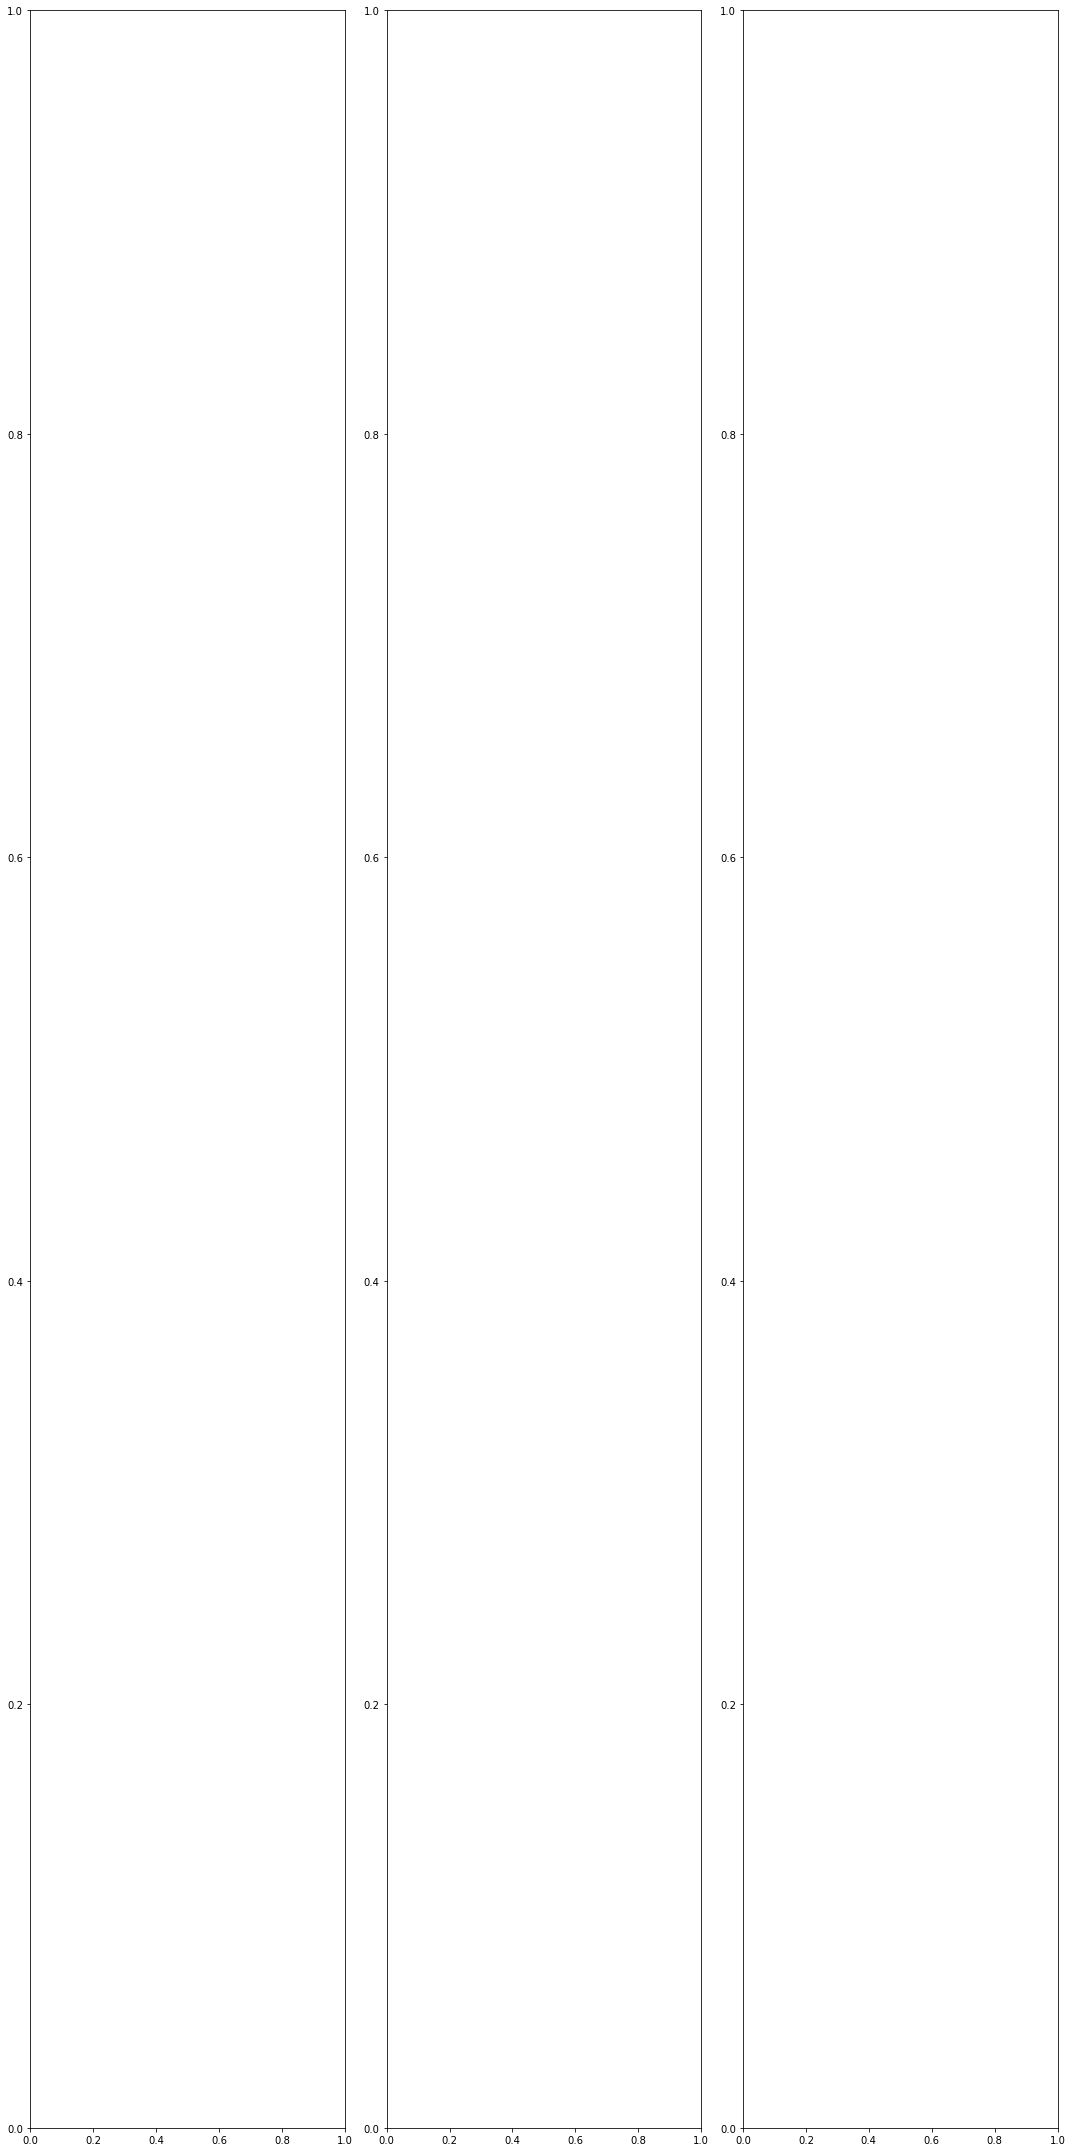

In [45]:
def add_rnd_bckgrnd( ):
    img_idx = random.randint( 0, len( img_files ) - 1 )
    path_bckgrnd_img = img_files[ img_idx ]
    bckgrnd_img = mpimg.imread( path_bckgrnd_img )

    obj_data_idx = random.randint( 0, len( obj_data_files ) - 1 )
    obj_data_path = obj_data_files[ obj_data_idx ]
    obj_data = load_obj_data(obj_data_path)
    path_img, path_img_z_map, path_img_class, path_img_z_img, path_img_class_img = get_file_name(obj_data)

    img           = mpimg.imread( path_img )
    img_z_map     = imageio.imread( path_img_z_map )
    img_class     = mpimg.imread( path_img_class )
    img_z_img     = mpimg.imread( path_img_z_img )
    img_class_img = mpimg.imread( path_img_class_img )

    ( offset, size ) = get_nontransparent_area( img )
    # Assumption: pixel ratio for all images is 1:1
    # Determine maximum scale for each dimension, then select
    # the maximum.
    # A scale < 1 means that the background image is smaller
    #             than the actual image and needs to be enlarged
    # A scale > 1 means that the background image is bigger and
    #             can be scaller from 1 downto scale
    # When the maximum allows downsizing, we choose
    # a random scale to downsize the image. If we need to enlarge
    # the image, we take the original image to not to loose details.
    max_scale_x = bckgrnd_img.shape[ 0 ] / img.shape[ 0 ]
    max_scale_y = bckgrnd_img.shape[ 1 ] / img.shape[ 1 ]
    max_scale = min( max_scale_x, max_scale_y )
    if max_scale > 1:
        scale = random.uniform( 1.0, max_scale )
        scale = math.floor( img.shape[ 0 ] * scale ) / img.shape[ 0 ]
    else:
        scale = max_scale
    crop_size = ( math.floor( img.shape[ 0 ] * scale ), math.floor( img.shape[ 1 ] * scale ) )
    # compute 
    max_offset_crop = [ a - b for ( a , b ) in zip( bckgrnd_img.shape[ 0 : 2 ], crop_size ) ]
    offset_crop = ( random.randint( 0, max_offset_crop[ 0 ] ), random.randint( 0, max_offset_crop[ 1 ] ) )

    ( y, x ) = offset_crop
    ( h, w ) = crop_size
    bckgrnd_crop_img = bckgrnd_img[y:y+h, x:x+w]
    bckgrnd_resize_img = cv2.resize( bckgrnd_crop_img, img.shape[ 1 :  : -1 ] )

    sy, sx, nc = bckgrnd_resize_img.shape
    if nc > 3:
        bckgrnd_resize_img = bckgrnd_resize_img[::,::,0:3:]
    elif nc < 3:
        print( "bckgrnd_resize_img has not enough color channels" )
        pass

    if isinstance( bckgrnd_resize_img[0][0][0], ( float, np.float32, np.float64 ) ):
        bckgrnd_resize_img = ( np.multiply( bckgrnd_resize_img, 255.0 ) ) [ :, :, : ]

    if isinstance( img[0][0][0], ( float, np.float32, np.float64 ) ):
        img_alpha = img[ ::, ::, 3:4: ]
        img_col = ( np.multiply( img, 255.0 ) ) [ ::, ::, 0:3: ]
    elif isinstance( img[0][0][0], ( int, np.uint8 ) ):
        img_alpha = ( np.multiply( img, 1.0 / 255 ) ) [ ::, ::, 3:4: ]
        img_col = img[ ::, ::, 0:3: ]

    sy, sx, _ = img_alpha.shape
    
    # compute mask
    # blend input image and overlay
    img_mixed = cv2.convertScaleAbs(img_col * img_alpha + bckgrnd_resize_img * (1.0 - img_alpha) )

    #return (img_mixed, bckgrnd_crop_img, bckgrnd_resize_img)
    return img_mixed

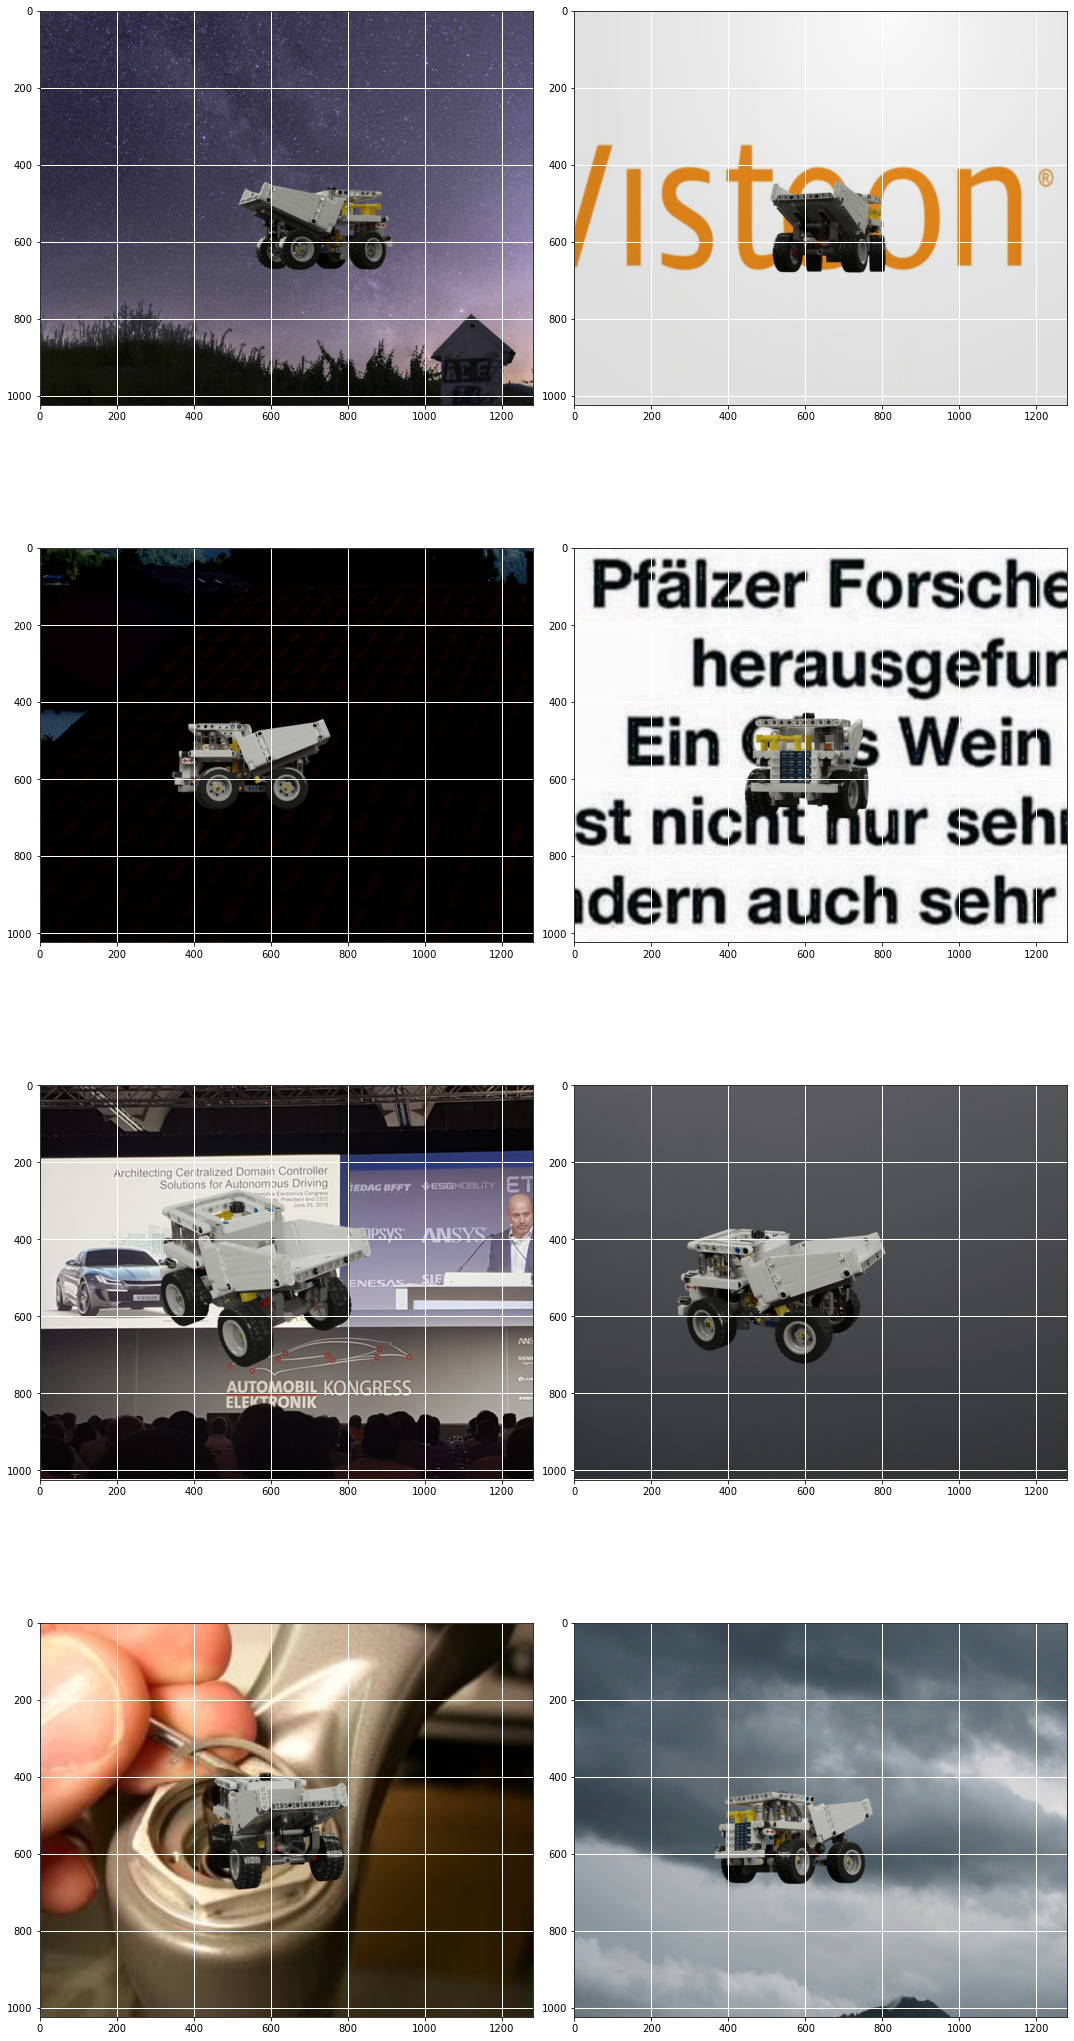

In [30]:
# draw the plots + bounding boxes
num_pics_x = 2
num_pics_y = 4
fig, axs = plt.subplots( num_pics_y, num_pics_x, figsize = ( 15, 30 ) )
fig.tight_layout()
for j in range( 0, num_pics_y ):
    for i in range( 0, num_pics_x ):
        img = add_rnd_bckgrnd( )
        if num_pics_x == 1 and num_pics_y == 1:
            p = axs
        elif num_pics_x == 1:
            p = axs[j]
        elif num_pics_y == 1:
            p = axs[i]
        else:
            p = axs[j,i]
        p.imshow( img )
        p.grid( color='w', linestyle='-', linewidth = 1 )
